In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import random
from torch.distributions import Normal, Categorical
from copy import deepcopy

In [2]:
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"

# DCEM with MLP

In [3]:
def deep_cross_entropy_loop(env, num_episodes=1000, elite_frac=0.8, num_samples=200, 
                       max_iter=500, depth=128, lr=0.01, goal=475):
    network = nn.Sequential(
        nn.Linear(env.observation_space.shape[0], depth),
        nn.ReLU(),
        nn.Linear(depth, depth),
        nn.ReLU(),
        nn.Linear(depth, env.action_space.n)
    ).to(device)
    softmax = nn.Softmax(dim=1)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)

    @torch.no_grad()
    def get_action(state, network):
        state = torch.FloatTensor(state).to(device)
        logits = network(state.unsqueeze(0))
        action_prob = softmax(logits).detach().cpu().numpy()[0]
        action = np.random.choice(len(action_prob), p=action_prob)
        return action

    def update_policy(network, elite_sessions):
        elite_states, elite_actions = [], []
        for session in elite_sessions:
            elite_states.extend(session['states'])
            elite_actions.extend(session['actions'])

        elite_states = torch.FloatTensor(elite_states).to(device)
        elite_actions = torch.LongTensor(elite_actions).to(device)

        optimizer.zero_grad()
        loss = loss_fn(network(elite_states), elite_actions)
        loss.backward()
        optimizer.step()

    def get_session(env, network, session_len=max_iter):
        states, actions = [], []
        total_reward = 0
        state = env.reset()

        for _ in range(session_len):
            states.append(state)
            action = get_action(state, network)
            actions.append(action)

            state, reward, done, _ = env.step(action)
            total_reward += reward

            if done:
                break

        return {'states': states, 'actions': actions, 'total_reward': total_reward}

    def get_elite_sessions(sessions, q_param):
        total_rewards = np.array([session['total_reward'] for session in sessions])
        quantile = np.quantile(total_rewards, q_param)

        return [session for session in sessions if session['total_reward'] >= quantile]

    mean_rewards = []

    for epoch in range(num_episodes):
        sessions = [get_session(env, network) for _ in range(num_samples)]
        elite_sessions = get_elite_sessions(sessions, elite_frac)
        if len(elite_sessions) < 1:
            print(f"Epoch {epoch} skipped")
            continue
        update_policy(network, elite_sessions)

        total_rewards = [session['total_reward'] for session in sessions]
        mean_total_rewards = np.mean(total_rewards)
        mean_rewards.extend(total_rewards)
        print(f"Epoch {epoch}, Mean Reward: {mean_total_rewards}")
        if np.mean(total_rewards[:-5]) >= goal:
            print("Converged!")
            break

    return mean_rewards

# DQN commons

In [4]:
class QFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
def dqn_loop(agent, env, num_episodes, t_max=500, goal=475):        
    total_rewards = []
    for episode in range(num_episodes):
        total_reward = 0
    
        state = env.reset()
        for t in range(t_max):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            agent.fit(state, action, reward, done, next_state)
            state = next_state
    
            if done:
                break

        total_rewards.append(total_reward)
        if len(total_rewards) >= 5 and np.mean(total_rewards[-5:]) >= goal:
            print("Converged!")
            break
        print(f'episode: {episode}, total_reward: {total_reward}')
    return total_rewards + [total_rewards[-1]] * (num_episodes - len(total_rewards))

# Unified DQN with support of Soft Target, Hard Target, and DDQN strategies

In [6]:
class DQNx:
    def __init__(self, state_dim, action_dim, gamma=1.0, eps_start=1.0, eps_min=0.01, eps_decay_factor=0.97, lr=0.001, batch_size=64, memory_size=10000, tau=0.5, target_update=10, DDQN=False):
        self.q_function = QFunction(state_dim, 128, action_dim).to(device)
        self.target_q_function = QFunction(state_dim, 128, action_dim).to(device)
        self.target_q_function.load_state_dict(self.q_function.state_dict())
        self.target_q_function.eval()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.epsilon = eps_start
        self.epsilon_decay = eps_decay_factor
        self.epsilon_min = eps_min
        self.memory_size = memory_size
        self.memory_counter = 0
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.q_function.parameters(), lr=lr)
        self.tau = tau
        self.target_update = target_update
        self.update_count = 0
        self.DDQN = DDQN

        # Preallocate memory
        self.states_memory = torch.empty((memory_size, state_dim), dtype=torch.float32, device=device)
        self.actions_memory = torch.empty((memory_size, 1), dtype=torch.int64, device=device)
        self.rewards_memory = torch.empty((memory_size, 1), dtype=torch.float32, device=device)
        self.dones_memory = torch.empty((memory_size, 1), dtype=torch.float32, device=device)
        self.next_states_memory = torch.empty((memory_size, state_dim), dtype=torch.float32, device=device)

        self.overestimation_tracker = []

    @torch.no_grad()
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(device)
                action_values = self.q_function(state_tensor)
                action = np.argmax(action_values.cpu().numpy()).item()
        return action

    def fit(self, state, action, reward, done, next_state):
        # Store experience in preallocated memory
        index = self.memory_counter % self.memory_size
        self.states_memory[index] = torch.from_numpy(state).to(device)
        self.actions_memory[index] = torch.tensor([action], device=device)
        self.rewards_memory[index] = torch.tensor([reward], device=device)
        self.dones_memory[index] = torch.tensor([done], device=device)
        self.next_states_memory[index] = torch.from_numpy(next_state).to(device)
        self.memory_counter += 1

        if self.memory_counter < self.batch_size:
            return

        indices = torch.randint(0, min(self.memory_counter, self.memory_size), (self.batch_size,), device=device)

        states = self.states_memory[indices]
        actions = self.actions_memory[indices]
        rewards = self.rewards_memory[indices]
        dones = self.dones_memory[indices]
        next_states = self.next_states_memory[indices]

        current_q_values = self.q_function(states).gather(1, actions)
        
        estimated_q_values = current_q_values.detach().cpu().numpy()
        actual_rewards = rewards.cpu().numpy()

        overestimation = np.mean(estimated_q_values - actual_rewards)
        self.overestimation_tracker.append(overestimation)
        
        with torch.no_grad():
            if self.DDQN:
                # Select the best action for next states using the primary network
                next_state_actions = self.q_function(next_states).max(1)[1].unsqueeze(1)
                
                # Evaluate the selected actions using the target network
                max_next_q_values = self.target_q_function(next_states).gather(1, next_state_actions)
            else:
                max_next_q_values = self.target_q_function(next_states).max(1)[0].unsqueeze(1)

            target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))
            
        loss = nn.MSELoss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.update_target_network()

    def update_target_network(self):
        if self.tau == 1 and self.update_count % self.target_update == 0:
            self.target_q_function.load_state_dict(self.q_function.state_dict())
        elif self.tau < 1:
            self.soft_update_target_network()
        self.update_count += 1

    def soft_update_target_network(self):
        for target_param, local_param in zip(self.target_q_function.parameters(), self.q_function.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def report_overestimation(self):
        if not self.overestimation_tracker:
            return "No overestimation data available."

        avg_overestimation = np.mean(self.overestimation_tracker)
        return f"Average Overestimation: {avg_overestimation}"

# PPO

In [7]:
# Vanilla PPO
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma = 1.0, batch_size=64, epsilon=0.2, pi_lr=1e-3, v_lr=1e-3, epoch_n=30):
        super().__init__()
        
        self.pi_model = nn.Sequential(
            nn.Linear(state_dim, 128), 
            nn.ReLU(), 
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1))
        self.v_model = nn.Sequential(
            nn.Linear(state_dim, 128), 
            nn.ReLU(), 
            nn.Linear(128, 128), 
            nn.ReLU(),
            nn.Linear(128, 1))
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)
        self.epoch_n = epoch_n

    @torch.no_grad()
    def get_action(self, state):
        state_tensor = torch.FloatTensor(state).to(device)        
        pi_out = self.pi_model(state_tensor.unsqueeze(0))
        dist = Categorical(probs=pi_out)
        action = dist.sample()
        return action.squeeze(0).cpu().numpy()

    def fit(self, states, actions, rewards, dones):
        states, action, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in range(rewards.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t+1]

        states, actions, returns = map(torch.FloatTensor, map(np.array, [states, actions, returns]))
        states = states.to(device)
        actions = actions.to(device)
        returns = returns.to(device)

        pi_out = self.pi_model(states)
        dist = Categorical(probs=pi_out)
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i:i + self.batch_size]
                b_states = states[b_idxs]
                b_actions  = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns - self.v_model(b_states)

                b_pi_out = self.pi_model(b_states)
                b_dist = Categorical(probs=b_pi_out)
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1 - self.epsilon, 1 + self.epsilon) * b_advantage.detach()
                
                pi_loss = -torch.mean(torch.min(pi_loss_1, pi_loss_2))
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [8]:
def ppo_loop(agent, env, num_episodes, num_trajectories=200, t_max=500, goal=475):
    total_rewards = []
    for episode in tqdm(range(num_episodes), desc="Episode"):
        states, actions, rewards, dones = [], [], [], []
    
        for _ in range(num_trajectories):
            state = env.reset()
            total_reward = 0
    
            for t in range(t_max):
                states.append(state)
                action = agent.get_action(state)
                actions.append(action)
        
                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                dones.append(done)
        
                total_reward += reward
                if done:
                    break
                    
            total_rewards.append(total_reward)
        agent.fit(states, actions, rewards, dones)

        print(f'episode: {episode}, total_reward: {total_reward}')

        if len(total_rewards) >= 5 and np.mean(total_rewards[-5:]) >= goal:
            print("Converged!")
            break            
        
    return total_rewards + [total_rewards[-1]] * (num_episodes - len(total_rewards))

# SAC

In [9]:
class SACD(nn.Module):
    def __init__(self, state_dim, action_dim, batch_size = 64, gamma=1.0, alpha=1e-3, tau=0.5, pi_lr=1e-3, q_lr=1e-3, temp = 0.5, memory_limit=10000):
        super().__init__()
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), 
                                      nn.ReLU(), 
                                      nn.Linear(128, 128),
                                      nn.ReLU(),
                                      nn.Linear(128, action_dim),
                                      nn.Softmax(dim=-1))
        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), 
                                      nn.ReLU(), 
                                      nn.Linear(128, 128),
                                      nn.ReLU(),
                                      nn.Linear(128, 1))
        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), 
                                      nn.ReLU(), 
                                      nn.Linear(128, 128),
                                      nn.ReLU(),
                                      nn.Linear(128, 1))        
        
        self.memory = []
        self.batch_size = batch_size
        self.action_dim = action_dim
        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)
        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)
        self.temperature = torch.FloatTensor([temp], device=device)
        self.memory_limit = 10000

    @torch.no_grad()
    def get_action(self, state):        
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.pi_model(state) 
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
    
        return action.cpu().item()
        
    def predict_actions(self, states):
        probs = self.pi_model(states)

        gumbel_softmax_dist = torch.distributions.RelaxedOneHotCategorical(self.temperature, probs=probs)
        soft_actions = gumbel_softmax_dist.rsample()
    
        log_probs = gumbel_softmax_dist.log_prob(soft_actions)
    
        return soft_actions, log_probs
        
    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) < self.batch_size:
            return

        self.memory = self.memory[-self.memory_limit:]
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
        rewards, dones = rewards.unsqueeze(-1), dones.unsqueeze(-1)
        actions = torch.nn.functional.one_hot(actions.long(), self.action_dim).float()
        
        next_actions, next_logprobs = self.predict_actions(next_states)
        
        next_states_actions = torch.cat((next_states, next_actions), dim=-1)
        next_q1_values = self.q1_target_model(next_states_actions)
        next_q2_values = self.q2_target_model(next_states_actions)
        next_min_q_values = torch.min(next_q1_values, next_q2_values)
        targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_logprobs)

        states_actions = torch.cat((states, actions), dim=-1)
        q1_values = self.q1_model(states_actions)
        q2_values = self.q2_model(states_actions)
        
        q1_loss = torch.mean((q1_values - targets.detach()) ** 2)
        q2_loss = torch.mean((q2_values - targets.detach()) ** 2)
        
        self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
        self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

        pred_actions, logprobs = self.predict_actions(states)
        states_and_pred_actions = torch.cat((states, pred_actions), dim=-1)
        n_q1_values = self.q1_model(states_and_pred_actions)
        n_q2_values = self.q2_model(states_and_pred_actions)
        min_q_values = torch.min(n_q1_values, n_q2_values)

        pi_loss = -torch.mean(min_q_values - self.alpha * logprobs)
        pi_loss.backward()
        self.pi_optimizer.step()
        self.pi_optimizer.zero_grad()

    def update_model(self, loss, optimizer, model, target_model):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        for param, target_param in zip(model.parameters(), target_model.parameters()):
            new_target_param = (1 - self.tau) * target_param + self.tau * param
            target_param.data.copy_(new_target_param)

In [10]:
def sacd_loop(agent, env, num_episodes, t_max=500, goal=475):        
    total_rewards = []
    for episode in range(num_episodes):
        total_reward = 0
    
        state = env.reset()
        for t in range(t_max):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            agent.fit(state, action, reward, done, next_state)
            state = next_state
    
            if done:
                break

        total_rewards.append(total_reward)
        if len(total_rewards) >= 5 and np.mean(total_rewards[-5:]) >= goal:
            print("Converged!")
            break
        print(f'episode: {episode}, total_reward: {total_reward}')
    return total_rewards + [total_rewards[-1]] * (num_episodes - len(total_rewards))

# Setup

In [11]:
env = gym.make('CartPole-v1')
run_count = 5
num_episodes = 1000
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Training

In [12]:
deep_cross_entropy_rewards = []
for i in tqdm(range(run_count), desc="Run"):
    deep_cross_entropy_rewards.append(deep_cross_entropy_loop(env, num_episodes=num_episodes, goal=475))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\pnaka\AppData\Local\Temp\ipykernel_28664\3651133222.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  elite_states = torch.FloatTensor(elite_states).to(device)


Epoch 0, Mean Reward: 22.66
Epoch 1, Mean Reward: 35.16
Epoch 2, Mean Reward: 55.01
Epoch 3, Mean Reward: 86.9
Epoch 4, Mean Reward: 132.395
Epoch 5, Mean Reward: 236.225
Epoch 6, Mean Reward: 298.975
Epoch 7, Mean Reward: 343.09
Epoch 8, Mean Reward: 320.18
Epoch 9, Mean Reward: 421.335
Epoch 10, Mean Reward: 483.835
Converged!
Epoch 0, Mean Reward: 23.265
Epoch 1, Mean Reward: 29.085
Epoch 2, Mean Reward: 45.04
Epoch 3, Mean Reward: 66.05
Epoch 4, Mean Reward: 71.935
Epoch 5, Mean Reward: 97.58
Epoch 6, Mean Reward: 119.615
Epoch 7, Mean Reward: 145.59
Epoch 8, Mean Reward: 244.125
Epoch 9, Mean Reward: 285.155
Epoch 10, Mean Reward: 339.535
Epoch 11, Mean Reward: 400.7
Epoch 12, Mean Reward: 469.075
Epoch 13, Mean Reward: 489.71
Converged!
Epoch 0, Mean Reward: 22.09
Epoch 1, Mean Reward: 27.835
Epoch 2, Mean Reward: 36.36
Epoch 3, Mean Reward: 48.155
Epoch 4, Mean Reward: 64.62
Epoch 5, Mean Reward: 75.16
Epoch 6, Mean Reward: 108.955
Epoch 7, Mean Reward: 153.98
Epoch 8, Mean Rewa

In [13]:
dqn_rewards = []
for i in tqdm(range(run_count), desc="Run"):
    dqn_agent = DQNx(state_dim, action_dim, tau=1, target_update=1)
    dqn_rewards.append(dqn_loop(dqn_agent, env, num_episodes=num_episodes, goal=475))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

episode: 0, total_reward: 31.0
episode: 1, total_reward: 13.0
episode: 2, total_reward: 11.0
episode: 3, total_reward: 24.0
episode: 4, total_reward: 17.0
episode: 5, total_reward: 10.0
episode: 6, total_reward: 8.0
episode: 7, total_reward: 9.0
episode: 8, total_reward: 10.0
episode: 9, total_reward: 10.0
episode: 10, total_reward: 11.0
episode: 11, total_reward: 8.0
episode: 12, total_reward: 9.0
episode: 13, total_reward: 10.0
episode: 14, total_reward: 9.0
episode: 15, total_reward: 9.0
episode: 16, total_reward: 11.0
episode: 17, total_reward: 8.0
episode: 18, total_reward: 42.0
episode: 19, total_reward: 31.0
episode: 20, total_reward: 35.0
episode: 21, total_reward: 61.0
episode: 22, total_reward: 27.0
episode: 23, total_reward: 40.0
episode: 24, total_reward: 62.0
episode: 25, total_reward: 74.0
episode: 26, total_reward: 68.0
episode: 27, total_reward: 45.0
episode: 28, total_reward: 76.0
episode: 29, total_reward: 86.0
episode: 30, total_reward: 75.0
episode: 31, total_reward

In [14]:
hard_dqn_rewards = []
for i in tqdm(range(run_count), desc="Run"):
    hard_dqn_agent = DQNx(state_dim, action_dim, tau=1, target_update=10)
    hard_dqn_rewards.append(dqn_loop(hard_dqn_agent, env, num_episodes=num_episodes, goal=475))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

episode: 0, total_reward: 36.0
episode: 1, total_reward: 17.0
episode: 2, total_reward: 15.0
episode: 3, total_reward: 30.0
episode: 4, total_reward: 10.0
episode: 5, total_reward: 10.0
episode: 6, total_reward: 12.0
episode: 7, total_reward: 12.0
episode: 8, total_reward: 11.0
episode: 9, total_reward: 12.0
episode: 10, total_reward: 10.0
episode: 11, total_reward: 10.0
episode: 12, total_reward: 40.0
episode: 13, total_reward: 22.0
episode: 14, total_reward: 16.0
episode: 15, total_reward: 18.0
episode: 16, total_reward: 27.0
episode: 17, total_reward: 105.0
episode: 18, total_reward: 147.0
episode: 19, total_reward: 71.0
episode: 20, total_reward: 96.0
episode: 21, total_reward: 113.0
episode: 22, total_reward: 119.0
episode: 23, total_reward: 87.0
episode: 24, total_reward: 119.0
episode: 25, total_reward: 209.0
episode: 26, total_reward: 187.0
episode: 27, total_reward: 286.0
episode: 28, total_reward: 316.0
episode: 29, total_reward: 171.0
episode: 30, total_reward: 244.0
episode

In [15]:
soft_dqn_rewards = []
for i in tqdm(range(run_count), desc="Run"):
    soft_dqn_agent = DQNx(state_dim, action_dim, tau=0.5, target_update=1)
    soft_dqn_rewards.append(dqn_loop(soft_dqn_agent, env, num_episodes=num_episodes, goal=475))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

episode: 0, total_reward: 30.0
episode: 1, total_reward: 29.0
episode: 2, total_reward: 35.0
episode: 3, total_reward: 17.0
episode: 4, total_reward: 11.0
episode: 5, total_reward: 9.0
episode: 6, total_reward: 12.0
episode: 7, total_reward: 11.0
episode: 8, total_reward: 9.0
episode: 9, total_reward: 9.0
episode: 10, total_reward: 10.0
episode: 11, total_reward: 10.0
episode: 12, total_reward: 10.0
episode: 13, total_reward: 9.0
episode: 14, total_reward: 11.0
episode: 15, total_reward: 13.0
episode: 16, total_reward: 12.0
episode: 17, total_reward: 16.0
episode: 18, total_reward: 16.0
episode: 19, total_reward: 13.0
episode: 20, total_reward: 17.0
episode: 21, total_reward: 12.0
episode: 22, total_reward: 16.0
episode: 23, total_reward: 24.0
episode: 24, total_reward: 22.0
episode: 25, total_reward: 25.0
episode: 26, total_reward: 44.0
episode: 27, total_reward: 77.0
episode: 28, total_reward: 52.0
episode: 29, total_reward: 26.0
episode: 30, total_reward: 47.0
episode: 31, total_rew

In [16]:
ddqn_rewards = []
for i in tqdm(range(run_count), desc="Run"):
    ddqn_agent = DQNx(state_dim, action_dim, tau=0.5, target_update=1, DDQN=True)
    ddqn_rewards.append(dqn_loop(ddqn_agent, env, num_episodes=num_episodes, goal=475))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

episode: 0, total_reward: 14.0
episode: 1, total_reward: 24.0
episode: 2, total_reward: 20.0
episode: 3, total_reward: 41.0
episode: 4, total_reward: 8.0
episode: 5, total_reward: 11.0
episode: 6, total_reward: 11.0
episode: 7, total_reward: 10.0
episode: 8, total_reward: 13.0
episode: 9, total_reward: 10.0
episode: 10, total_reward: 11.0
episode: 11, total_reward: 36.0
episode: 12, total_reward: 20.0
episode: 13, total_reward: 12.0
episode: 14, total_reward: 33.0
episode: 15, total_reward: 10.0
episode: 16, total_reward: 41.0
episode: 17, total_reward: 46.0
episode: 18, total_reward: 52.0
episode: 19, total_reward: 64.0
episode: 20, total_reward: 36.0
episode: 21, total_reward: 169.0
episode: 22, total_reward: 223.0
episode: 23, total_reward: 268.0
episode: 24, total_reward: 428.0
episode: 25, total_reward: 262.0
episode: 26, total_reward: 267.0
episode: 27, total_reward: 316.0
episode: 28, total_reward: 342.0
episode: 29, total_reward: 500.0
episode: 30, total_reward: 500.0
episode: 

In [17]:
ppo_rewards = []
for i in tqdm(range(run_count), desc="Run"):
    ppo_agent = PPO(state_dim, action_dim)
    ppo_rewards.append(ppo_loop(ppo_agent, env, num_episodes=num_episodes, goal=475))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode: 0, total_reward: 18.0
episode: 1, total_reward: 18.0
episode: 2, total_reward: 31.0
episode: 3, total_reward: 46.0
episode: 4, total_reward: 61.0
episode: 5, total_reward: 83.0
episode: 6, total_reward: 42.0
episode: 7, total_reward: 81.0
episode: 8, total_reward: 63.0
episode: 9, total_reward: 200.0
episode: 10, total_reward: 110.0
episode: 11, total_reward: 93.0
episode: 12, total_reward: 269.0
episode: 13, total_reward: 106.0
episode: 14, total_reward: 68.0
episode: 15, total_reward: 30.0
episode: 16, total_reward: 156.0
episode: 17, total_reward: 134.0
episode: 18, total_reward: 272.0
episode: 19, total_reward: 360.0
episode: 20, total_reward: 433.0
episode: 21, total_reward: 347.0
episode: 22, total_reward: 223.0
episode: 23, total_reward: 380.0
episode: 24, total_reward: 221.0
episode: 25, total_reward: 259.0
episode: 26, total_reward: 500.0
episode: 27, total_reward: 500.0
episode: 28, total_reward: 500.0
episode: 29, total_reward: 490.0
episode: 30, total_reward: 500.0

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode: 0, total_reward: 25.0
episode: 1, total_reward: 14.0
episode: 2, total_reward: 41.0
episode: 3, total_reward: 34.0
episode: 4, total_reward: 22.0
episode: 5, total_reward: 55.0
episode: 6, total_reward: 95.0
episode: 7, total_reward: 65.0
episode: 8, total_reward: 264.0
episode: 9, total_reward: 94.0
episode: 10, total_reward: 57.0
episode: 11, total_reward: 215.0
episode: 12, total_reward: 160.0
episode: 13, total_reward: 134.0
episode: 14, total_reward: 131.0
episode: 15, total_reward: 85.0
episode: 16, total_reward: 220.0
episode: 17, total_reward: 127.0
episode: 18, total_reward: 187.0
episode: 19, total_reward: 416.0
episode: 20, total_reward: 500.0
episode: 21, total_reward: 204.0
episode: 22, total_reward: 68.0
episode: 23, total_reward: 423.0
episode: 24, total_reward: 221.0
episode: 25, total_reward: 272.0
episode: 26, total_reward: 323.0
episode: 27, total_reward: 161.0
episode: 28, total_reward: 214.0
episode: 29, total_reward: 500.0
episode: 30, total_reward: 500.0

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode: 0, total_reward: 22.0
episode: 1, total_reward: 17.0
episode: 2, total_reward: 63.0
episode: 3, total_reward: 44.0
episode: 4, total_reward: 58.0
episode: 5, total_reward: 11.0
episode: 6, total_reward: 130.0
episode: 7, total_reward: 135.0
episode: 8, total_reward: 210.0
episode: 9, total_reward: 171.0
episode: 10, total_reward: 325.0
episode: 11, total_reward: 152.0
episode: 12, total_reward: 132.0
episode: 13, total_reward: 266.0
episode: 14, total_reward: 269.0
episode: 15, total_reward: 283.0
episode: 16, total_reward: 500.0
episode: 17, total_reward: 500.0
episode: 18, total_reward: 500.0
episode: 19, total_reward: 500.0
Converged!


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode: 0, total_reward: 11.0
episode: 1, total_reward: 28.0
episode: 2, total_reward: 70.0
episode: 3, total_reward: 20.0
episode: 4, total_reward: 38.0
episode: 5, total_reward: 20.0
episode: 6, total_reward: 118.0
episode: 7, total_reward: 132.0
episode: 8, total_reward: 122.0
episode: 9, total_reward: 271.0
episode: 10, total_reward: 176.0
episode: 11, total_reward: 235.0
episode: 12, total_reward: 336.0
episode: 13, total_reward: 181.0
episode: 14, total_reward: 240.0
episode: 15, total_reward: 253.0
episode: 16, total_reward: 277.0
episode: 17, total_reward: 286.0
episode: 18, total_reward: 500.0
episode: 19, total_reward: 500.0
episode: 20, total_reward: 189.0
episode: 21, total_reward: 500.0
episode: 22, total_reward: 500.0
episode: 23, total_reward: 449.0
Converged!


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

episode: 0, total_reward: 25.0
episode: 1, total_reward: 24.0
episode: 2, total_reward: 27.0
episode: 3, total_reward: 27.0
episode: 4, total_reward: 130.0
episode: 5, total_reward: 26.0
episode: 6, total_reward: 71.0
episode: 7, total_reward: 61.0
episode: 8, total_reward: 93.0
episode: 9, total_reward: 97.0
episode: 10, total_reward: 72.0
episode: 11, total_reward: 54.0
episode: 12, total_reward: 115.0
episode: 13, total_reward: 212.0
episode: 14, total_reward: 55.0
episode: 15, total_reward: 328.0
episode: 16, total_reward: 55.0
episode: 17, total_reward: 179.0
episode: 18, total_reward: 141.0
episode: 19, total_reward: 500.0
episode: 20, total_reward: 500.0
Converged!


In [20]:
sacd_rewards = []
for i in tqdm(range(run_count), desc="Run"):
    sacd_agent = SACD(state_dim, action_dim, temp=0.35, memory_limit=1000)
    sacd_rewards.append(sacd_loop(sacd_agent, env, num_episodes=num_episodes, goal=475))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

episode: 0, total_reward: 15.0
episode: 1, total_reward: 22.0
episode: 2, total_reward: 20.0
episode: 3, total_reward: 18.0
episode: 4, total_reward: 11.0
episode: 5, total_reward: 10.0
episode: 6, total_reward: 9.0
episode: 7, total_reward: 10.0
episode: 8, total_reward: 8.0
episode: 9, total_reward: 9.0
episode: 10, total_reward: 8.0
episode: 11, total_reward: 10.0
episode: 12, total_reward: 10.0
episode: 13, total_reward: 11.0
episode: 14, total_reward: 20.0
episode: 15, total_reward: 16.0
episode: 16, total_reward: 10.0
episode: 17, total_reward: 10.0
episode: 18, total_reward: 8.0
episode: 19, total_reward: 10.0
episode: 20, total_reward: 10.0
episode: 21, total_reward: 9.0
episode: 22, total_reward: 10.0
episode: 23, total_reward: 10.0
episode: 24, total_reward: 10.0
episode: 25, total_reward: 8.0
episode: 26, total_reward: 8.0
episode: 27, total_reward: 10.0
episode: 28, total_reward: 10.0
episode: 29, total_reward: 81.0
episode: 30, total_reward: 100.0
episode: 31, total_reward

# Results and plots

In [21]:
def pad_to_longest(src):
    max_length = max(len(item) for item in src)
    for idx, item in enumerate(src):
        src[idx] = item + item[-2:-1] * (max_length - len(item))
    return src

In [22]:
p_deep_cross_entropy_rewards = pad_to_longest(deep_cross_entropy_rewards)
p_dqn_rewards = pad_to_longest(dqn_rewards)
p_hard_dqn_rewards = pad_to_longest(hard_dqn_rewards)
p_soft_dqn_rewards = pad_to_longest(soft_dqn_rewards)
p_ddqn_rewards = pad_to_longest(ddqn_rewards)
p_ppo_rewards = pad_to_longest(ppo_rewards)
p_sacd_rewards = pad_to_longest(sacd_rewards)

In [23]:
m_deep_cross_entropy_rewards, std_deep_cross_entropy_rewards = np.mean(p_deep_cross_entropy_rewards, axis=0), np.std(p_deep_cross_entropy_rewards, axis=0)
m_dqn_rewards, std_dqn_rewards = np.mean(p_dqn_rewards, axis=0), np.std(p_dqn_rewards, axis=0)
m_hard_dqn_rewards, std_hard_dqn_rewards = np.mean(p_hard_dqn_rewards, axis=0), np.std(p_hard_dqn_rewards, axis=0)
m_soft_dqn_rewards, std_soft_dqn_rewards = np.mean(p_soft_dqn_rewards, axis=0), np.std(p_soft_dqn_rewards, axis=0)
m_ddqn_rewards, std_ddqn_rewards = np.mean(p_ddqn_rewards, axis=0), np.std(p_ddqn_rewards, axis=0)
m_ppo_rewards, std_ppo_rewards  = np.mean(p_ppo_rewards, axis=0), np.std(p_ppo_rewards, axis=0)
m_sacd_rewards, std_sacd_rewards = np.mean(p_sacd_rewards, axis=0), np.std(p_sacd_rewards, axis=0)

In [24]:
window_size = 50

smoothed_deep_cross_entropy_rewards = np.convolve(m_deep_cross_entropy_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_dqn_rewards = np.convolve(m_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_hard_dqn_rewards = np.convolve(m_hard_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_soft_dqn_rewards = np.convolve(m_soft_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_ddqn_rewards = np.convolve(m_ddqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_ppo_rewards = np.convolve(m_ppo_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_sacd_rewards = np.convolve(m_sacd_rewards, np.ones(window_size)/window_size, mode='valid')

smoothed_deep_cross_entropy_rewards_std = np.convolve(std_deep_cross_entropy_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_dqn_rewards_std = np.convolve(std_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_hard_dqn_rewards_std = np.convolve(std_hard_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_soft_dqn_rewards_std = np.convolve(std_soft_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_ddqn_rewards_std = np.convolve(std_ddqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_ppo_rewards_std = np.convolve(std_ppo_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_sacd_rewards_std = np.convolve(std_sacd_rewards, np.ones(window_size)/window_size, mode='valid')

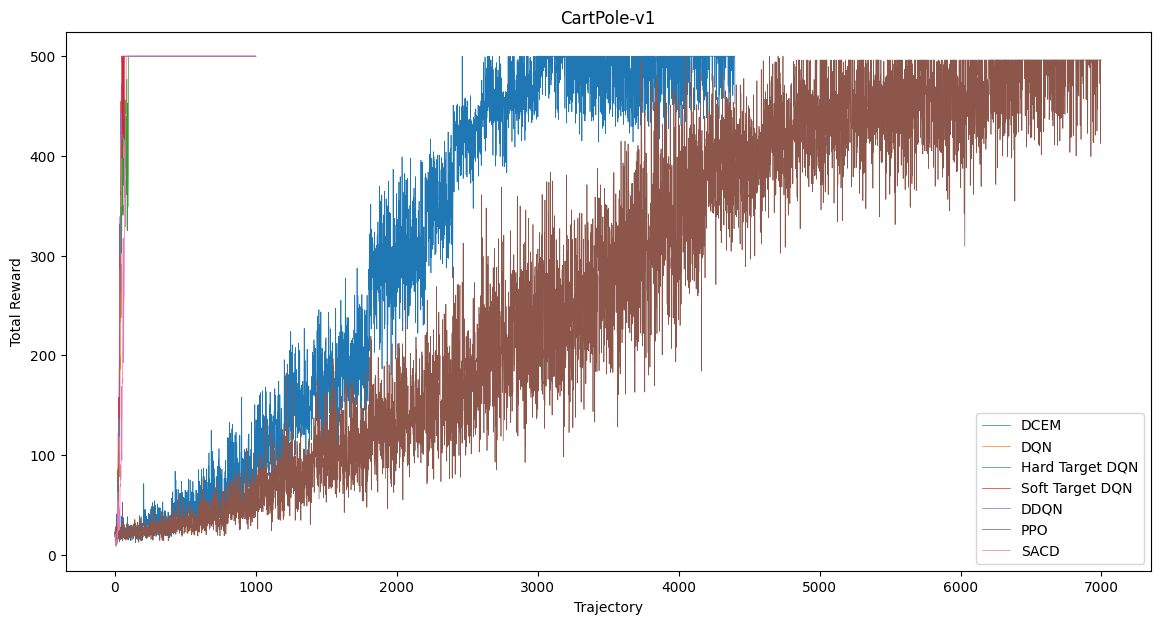

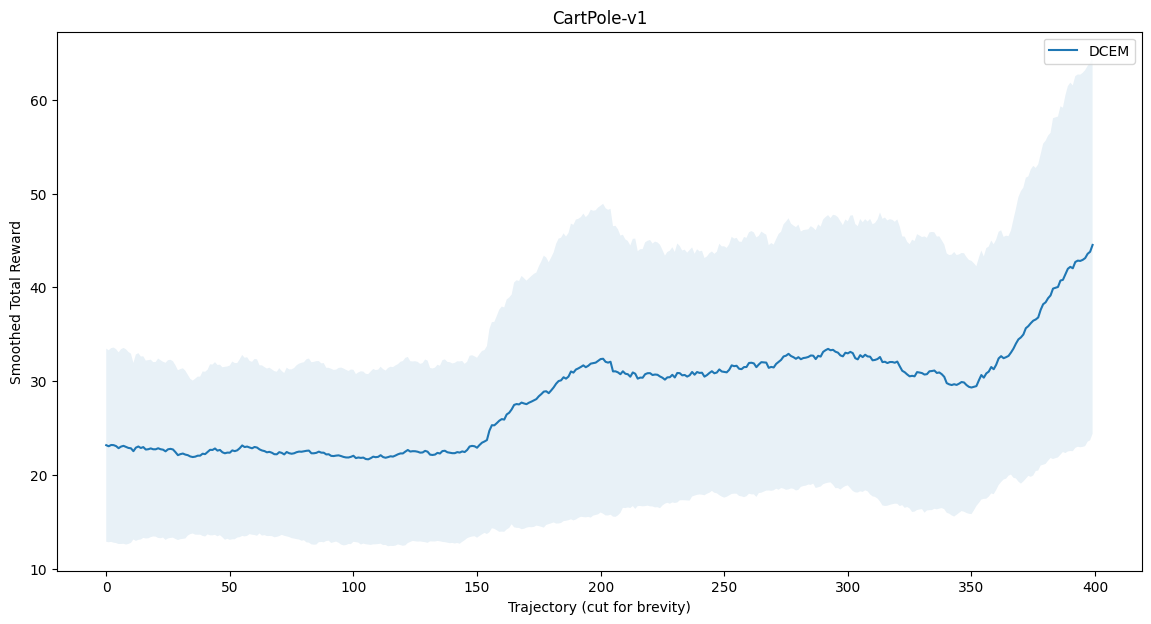

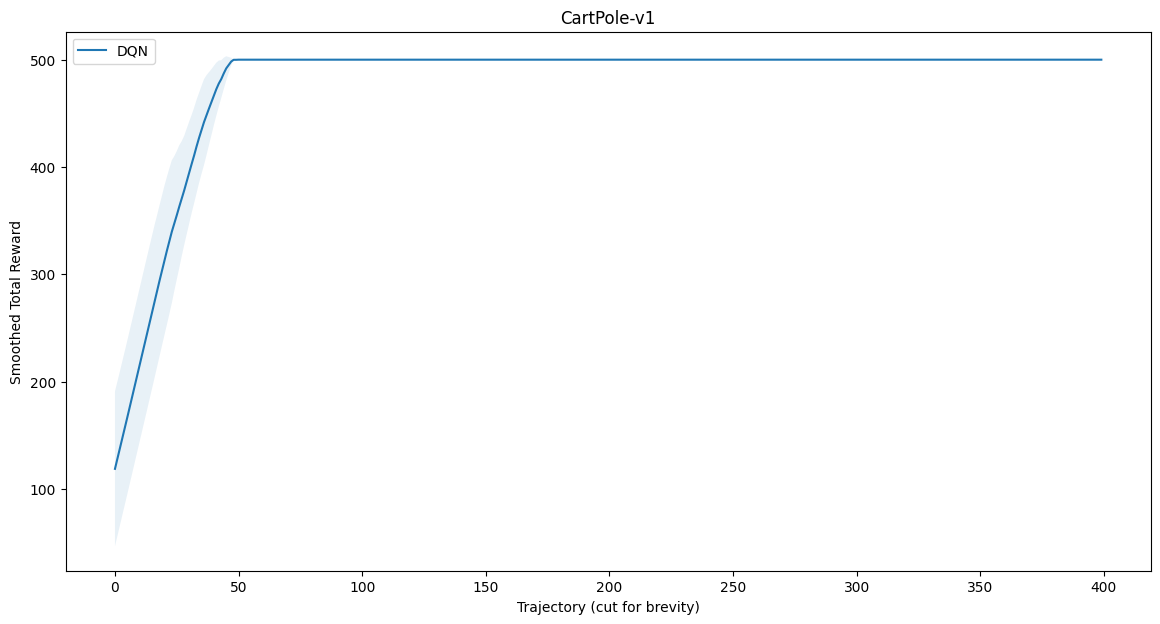

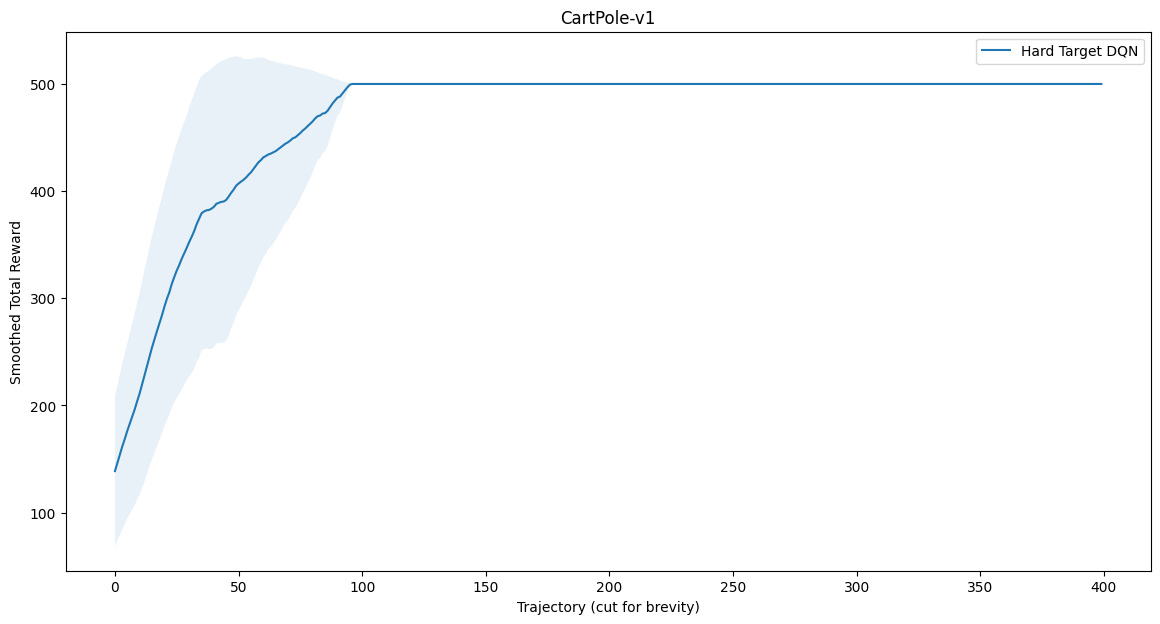

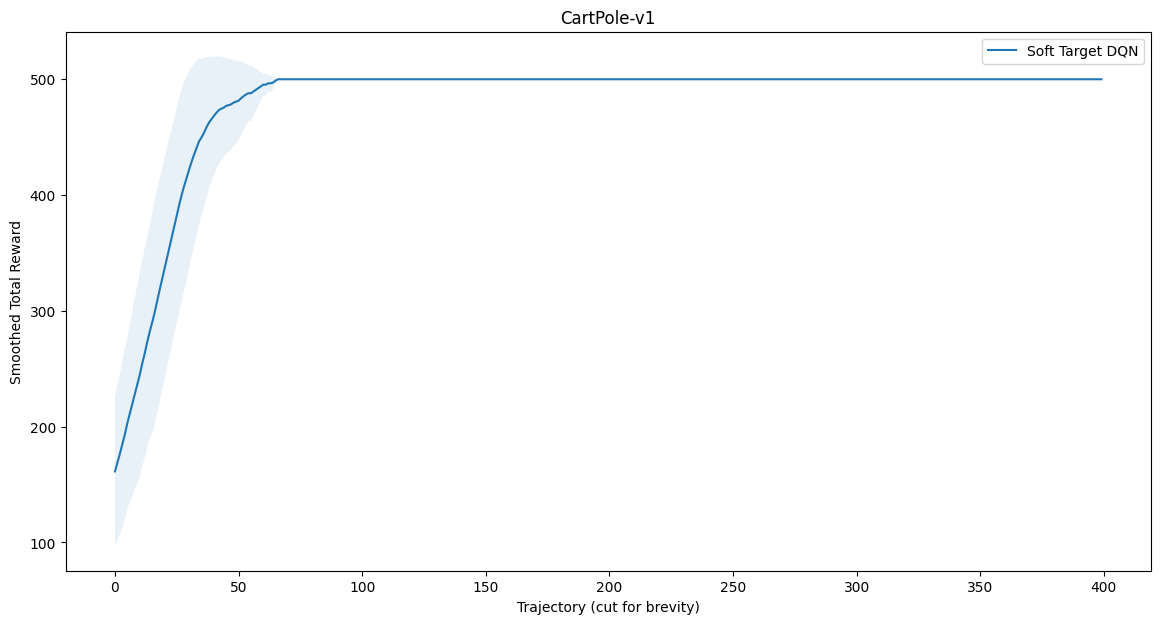

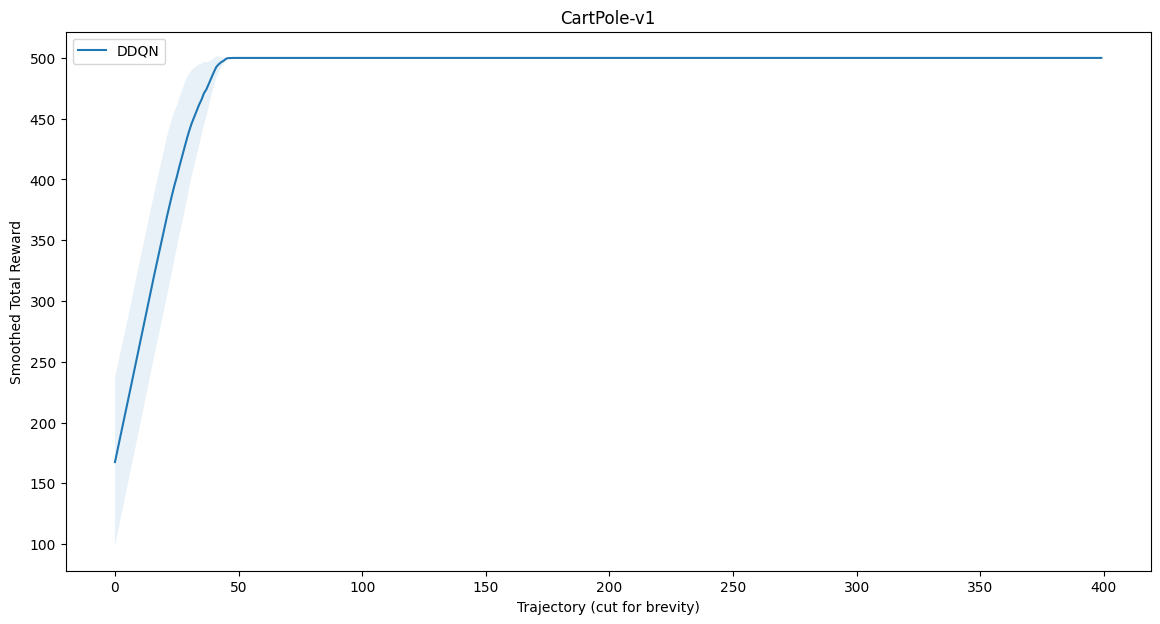

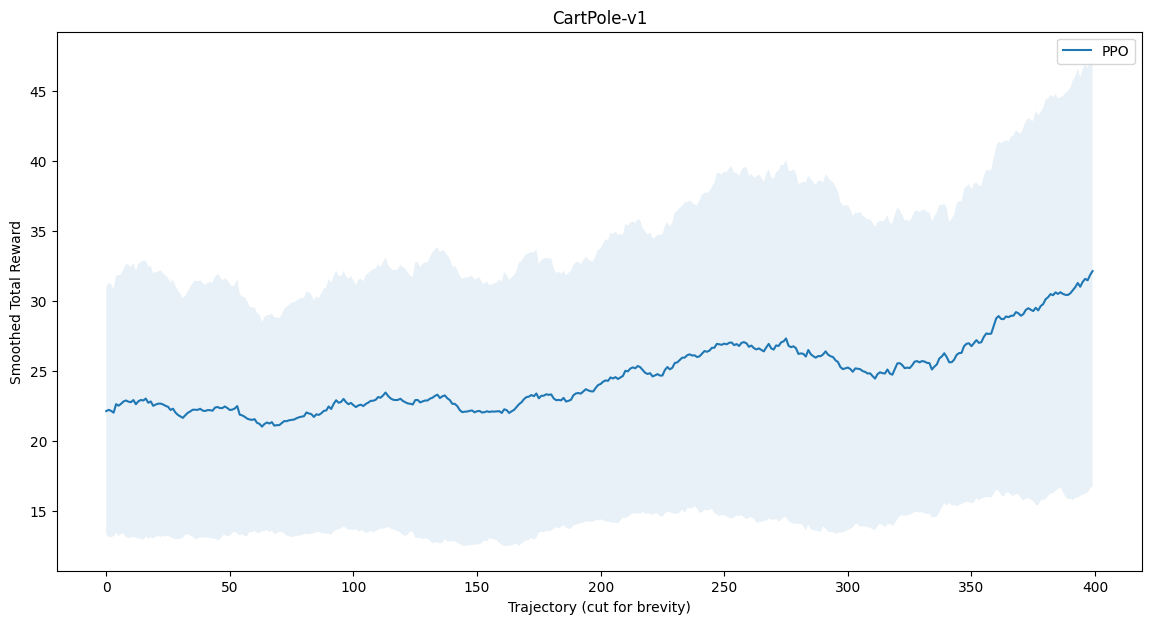

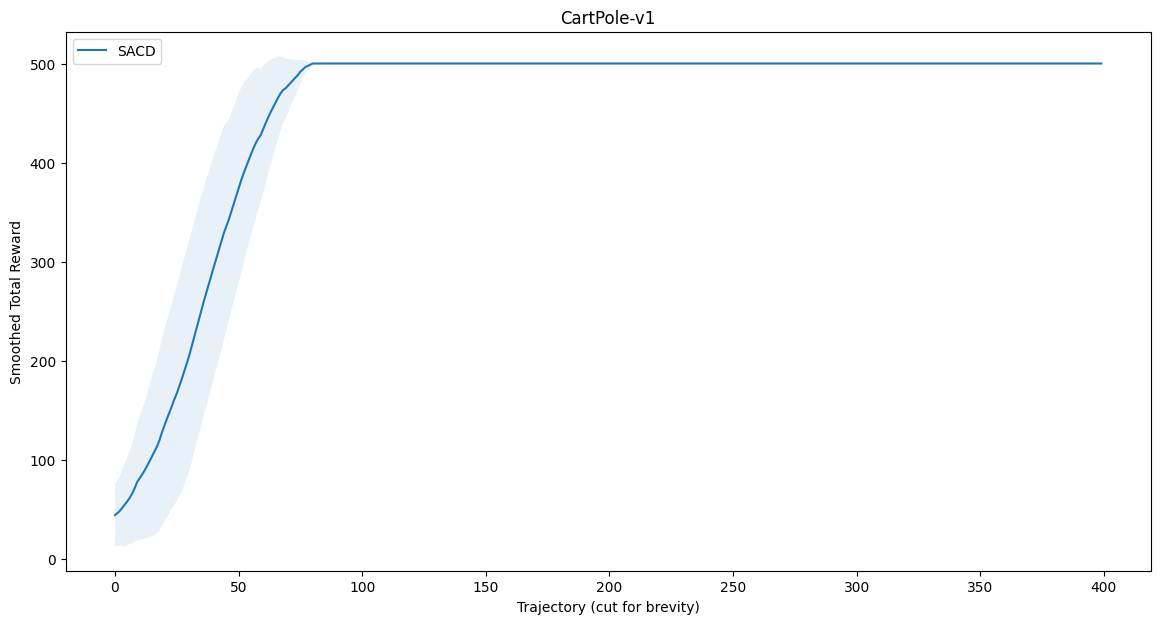

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(m_deep_cross_entropy_rewards, label='DCEM', linewidth=0.5)
plt.plot(m_dqn_rewards, label='DQN', linewidth=0.5)
plt.plot(m_hard_dqn_rewards, label='Hard Target DQN', linewidth=0.5)
plt.plot(m_soft_dqn_rewards, label='Soft Target DQN', linewidth=0.5)
plt.plot(m_ddqn_rewards, label='DDQN', linewidth=0.5)
plt.plot(m_ppo_rewards, label='PPO', linewidth=0.5)
plt.plot(m_sacd_rewards, label='SACD', linewidth=0.5)
plt.xlabel('Trajectory')
plt.ylabel('Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()


plt.figure(figsize=(14,7)) 
plt.plot(smoothed_deep_cross_entropy_rewards[:400], label='DCEM', linewidth=1.5)
plt.fill_between(range(len(smoothed_deep_cross_entropy_rewards[:400])), 
                 smoothed_deep_cross_entropy_rewards[:400] - smoothed_deep_cross_entropy_rewards_std[:400], 
                 smoothed_deep_cross_entropy_rewards[:400] + smoothed_deep_cross_entropy_rewards_std[:400], alpha=0.1)
plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

plt.figure(figsize=(14,7)) 
plt.plot(smoothed_dqn_rewards[:400], label='DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_dqn_rewards[:400])), 
                 smoothed_dqn_rewards[:400] - smoothed_dqn_rewards_std[:400], 
                 smoothed_dqn_rewards[:400] + smoothed_dqn_rewards_std[:400], alpha=0.1)
plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

plt.figure(figsize=(14,7)) 
plt.plot(smoothed_hard_dqn_rewards[:400], label='Hard Target DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_hard_dqn_rewards[:400])), 
                 smoothed_hard_dqn_rewards[:400] - smoothed_hard_dqn_rewards_std[:400], 
                 smoothed_hard_dqn_rewards[:400] + smoothed_hard_dqn_rewards_std[:400], alpha=0.1)
plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

plt.figure(figsize=(14,7)) 
plt.plot(smoothed_soft_dqn_rewards[:400], label='Soft Target DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_soft_dqn_rewards[:400])), 
                 smoothed_soft_dqn_rewards[:400] - smoothed_soft_dqn_rewards_std[:400], 
                 smoothed_soft_dqn_rewards[:400] + smoothed_soft_dqn_rewards_std[:400], alpha=0.1)
plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

plt.figure(figsize=(14,7)) 
plt.plot(smoothed_ddqn_rewards[:400], label='DDQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_ddqn_rewards[:400])), 
                 smoothed_ddqn_rewards[:400] - smoothed_ddqn_rewards_std[:400], 
                 smoothed_ddqn_rewards[:400] + smoothed_ddqn_rewards_std[:400], alpha=0.1)
plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

plt.figure(figsize=(14,7)) 
plt.plot(smoothed_ppo_rewards[:400], label='PPO', linewidth=1.5)
plt.fill_between(range(len(smoothed_ppo_rewards[:400])), 
                 smoothed_ppo_rewards[:400] - smoothed_ppo_rewards_std[:400], 
                 smoothed_ppo_rewards[:400] + smoothed_ppo_rewards_std[:400], alpha=0.1)
plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

plt.figure(figsize=(14,7)) 
plt.plot(smoothed_sacd_rewards[:400], label='SACD', linewidth=1.5)
plt.fill_between(range(len(smoothed_sacd_rewards[:400])), 
                 smoothed_sacd_rewards[:400] - smoothed_sacd_rewards_std[:400], 
                 smoothed_sacd_rewards[:400] + smoothed_sacd_rewards_std[:400], alpha=0.1)

plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

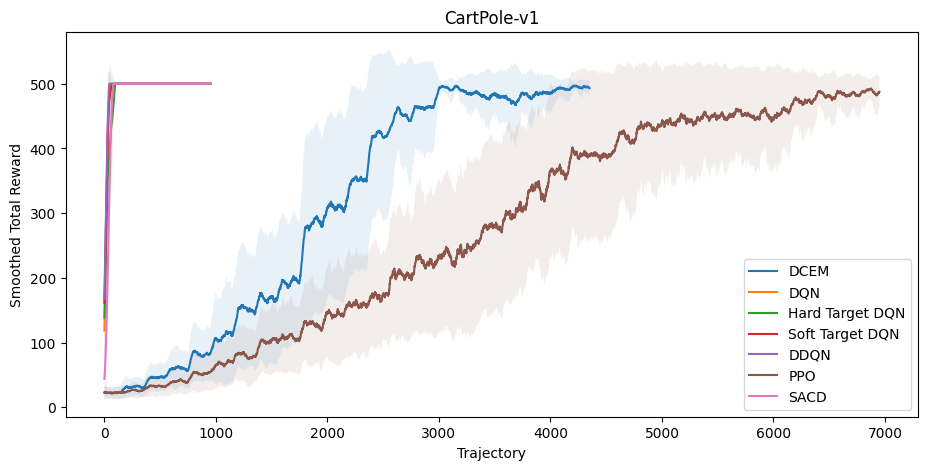

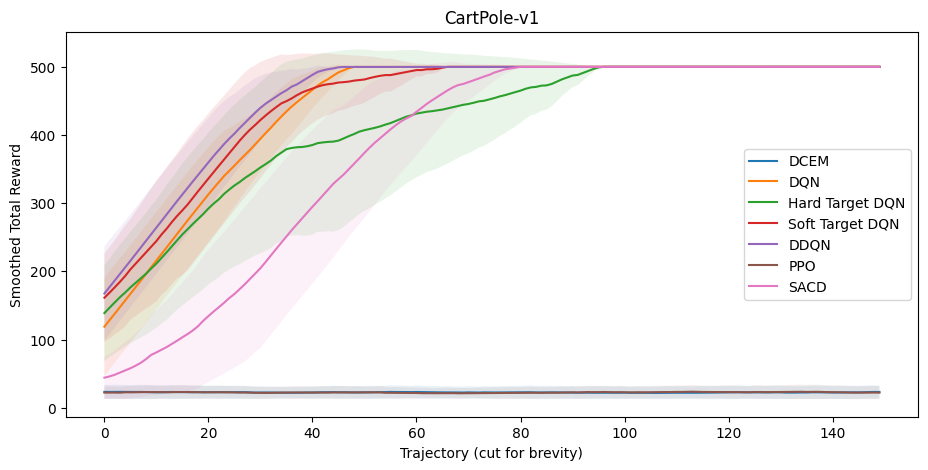

In [31]:
plt.figure(figsize=(11, 5))

plt.plot(smoothed_deep_cross_entropy_rewards, label='DCEM', linewidth=1.5)
plt.fill_between(range(len(smoothed_deep_cross_entropy_rewards)), 
                 smoothed_deep_cross_entropy_rewards - smoothed_deep_cross_entropy_rewards_std, 
                 smoothed_deep_cross_entropy_rewards + smoothed_deep_cross_entropy_rewards_std, alpha=0.1)

plt.plot(smoothed_dqn_rewards, label='DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_dqn_rewards)), 
                 smoothed_dqn_rewards - smoothed_dqn_rewards_std, 
                 smoothed_dqn_rewards + smoothed_dqn_rewards_std, alpha=0.1)

plt.plot(smoothed_hard_dqn_rewards, label='Hard Target DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_hard_dqn_rewards)), 
                 smoothed_hard_dqn_rewards - smoothed_hard_dqn_rewards_std, 
                 smoothed_hard_dqn_rewards + smoothed_hard_dqn_rewards_std, alpha=0.1)

plt.plot(smoothed_soft_dqn_rewards, label='Soft Target DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_soft_dqn_rewards)), 
                 smoothed_soft_dqn_rewards - smoothed_soft_dqn_rewards_std, 
                 smoothed_soft_dqn_rewards + smoothed_soft_dqn_rewards_std, alpha=0.1)

plt.plot(smoothed_ddqn_rewards, label='DDQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_ddqn_rewards)), 
                 smoothed_ddqn_rewards - smoothed_ddqn_rewards_std, 
                 smoothed_ddqn_rewards + smoothed_ddqn_rewards_std, alpha=0.1)

plt.plot(smoothed_ppo_rewards, label='PPO', linewidth=1.5)
plt.fill_between(range(len(smoothed_ppo_rewards)), 
                 smoothed_ppo_rewards - smoothed_ppo_rewards_std, 
                 smoothed_ppo_rewards + smoothed_ppo_rewards_std, alpha=0.1)

plt.plot(smoothed_sacd_rewards, label='SACD', linewidth=1.5)
plt.fill_between(range(len(smoothed_sacd_rewards)), 
                 smoothed_sacd_rewards - smoothed_sacd_rewards_std, 
                 smoothed_sacd_rewards + smoothed_sacd_rewards_std, alpha=0.1)

plt.xlabel('Trajectory')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()
plt.show()

plt.figure(figsize=(11,5)) 
plt.plot(smoothed_deep_cross_entropy_rewards[:150], label='DCEM', linewidth=1.5)
plt.fill_between(range(len(smoothed_deep_cross_entropy_rewards[:150])), 
                 smoothed_deep_cross_entropy_rewards[:150] - smoothed_deep_cross_entropy_rewards_std[:150], 
                 smoothed_deep_cross_entropy_rewards[:150] + smoothed_deep_cross_entropy_rewards_std[:150], alpha=0.1)

plt.plot(smoothed_dqn_rewards[:150], label='DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_dqn_rewards[:150])), 
                 smoothed_dqn_rewards[:150] - smoothed_dqn_rewards_std[:150], 
                 smoothed_dqn_rewards[:150] + smoothed_dqn_rewards_std[:150], alpha=0.1)

plt.plot(smoothed_hard_dqn_rewards[:150], label='Hard Target DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_hard_dqn_rewards[:150])), 
                 smoothed_hard_dqn_rewards[:150] - smoothed_hard_dqn_rewards_std[:150], 
                 smoothed_hard_dqn_rewards[:150] + smoothed_hard_dqn_rewards_std[:150], alpha=0.1)

plt.plot(smoothed_soft_dqn_rewards[:150], label='Soft Target DQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_soft_dqn_rewards[:150])), 
                 smoothed_soft_dqn_rewards[:150] - smoothed_soft_dqn_rewards_std[:150], 
                 smoothed_soft_dqn_rewards[:150] + smoothed_soft_dqn_rewards_std[:150], alpha=0.1)

plt.plot(smoothed_ddqn_rewards[:150], label='DDQN', linewidth=1.5)
plt.fill_between(range(len(smoothed_ddqn_rewards[:150])), 
                 smoothed_ddqn_rewards[:150] - smoothed_ddqn_rewards_std[:150], 
                 smoothed_ddqn_rewards[:150] + smoothed_ddqn_rewards_std[:150], alpha=0.1)

plt.plot(smoothed_ppo_rewards[:150], label='PPO', linewidth=1.5)
plt.fill_between(range(len(smoothed_ppo_rewards[:150])), 
                 smoothed_ppo_rewards[:150] - smoothed_ppo_rewards_std[:150], 
                 smoothed_ppo_rewards[:150] + smoothed_ppo_rewards_std[:150], alpha=0.1)

plt.plot(smoothed_sacd_rewards[:150], label='SACD', linewidth=1.5)
plt.fill_between(range(len(smoothed_sacd_rewards[:150])), 
                 smoothed_sacd_rewards[:150] - smoothed_sacd_rewards_std[:150], 
                 smoothed_sacd_rewards[:150] + smoothed_sacd_rewards_std[:150], alpha=0.1)

plt.xlabel('Trajectory (cut for brevity)')
plt.ylabel('Smoothed Total Reward')
plt.title("CartPole-v1")
plt.legend()

# Analysis and Conclusion

* Both DCEM and PPO demonstrate relatively same poor performance and stability on CartPole-v1. These required order of magnitude more generated trajectories to converge.
* DQN family of algroithms demonstrate best stability and performance compared to others
* All DQN based policies seem to require relatively the same amount of trajectories to converge
* SACD (SAC for Discrete Action space) demonstrates good performance, a decent stability and performance comparable to DQN as expected.

### Notes on SACD
Because vanilla design of SAC assumes continous action space, some adjustments were needed to be made to the way we sample actions (https://arxiv.org/pdf/2109.08512.pdf). 

Categorical distribution is not differentiatible, so instead we use RelaxedOneHotCategorical distribution, which in Pytorch is implemented by adding Gumbel noise to logits before the softmax and could be differentiated. 

That way we reformulate the approach for discrete action space using Gumbel Softmax Reparametrization trick, which yields decent results. 